<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/Plots_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Github
%%capture

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI

import sys
!{sys.executable} -m pip install ipympl

In [2]:
#@title Existing temperatures
!ls "MD-SCPI/PDBs/MC/AS4/"

10000K	20000K	4800K	    600K	 box.pdb	 MR.mol2.gz
1200K	2400K	5000K	    9600K	 libela.sub
15000K	300K	5000K_long  AS4.mol2.gz  MR-AS4.mol2.gz


In [3]:
import gzip
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from google.colab import output
import numpy as np
import matplotlib as mpl
from scipy.stats import linregress
import matplotlib.cm as cm
from matplotlib import gridspec
import matplotlib.colors as mcolors
from scipy.optimize import root


def ReadGz(path):
  #data = pd.read_csv(path, compression='gzip',  header=4, delimiter="  ")[['#', 'Step', 'Unnamed: 6', 'Unnamed: 7', ' RMSD']].rename({'#':'Step', 'Step':'Energy', 'Unnamed: 6':'RMSD', 'Unnamed: 7':'DX', ' RMSD':'DY'}, axis=1)
  file1 = gzip.open(path)
  a = file1.read()

  array, c = [], 0
  text = str(a).split()[11:]
  head = text[:14] # 20 

  for i in range(20,len(text)):
    c += 1
    if '\\n' in text[i]:
      text[i] = text[i].replace("\\n","")
      text[i] = text[i].replace("'","")
      words = [float(word) for word in text[i-c+1:i+1]]
      array.append(words) #text[i-c+1:i+1])
      c = 0

  array = np.array(array)
  data = pd.DataFrame({head[i]:array[:,i] for i in range(len(head))})
  return data

%matplotlib ipympl
output.enable_custom_widget_manager()

In [4]:
#file1 = gzip.open('MD-SCPI/PDBs/MC/AS4/300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz')
#ReadGz('MD-SCPI/PDBs/MC/AS4/300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz')['Step']

In [5]:
temperatures = ['300K', '600K', '1200K', '2400K', '4800K', '5000K']
high_temperatures = ['9600K', '10000K', '15000K', '20000K']
colors = ['gray', 'violet', 'red', 'green', 'orange', 'blue', 'orchid']
several_colors = sorted(mcolors.CSS4_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
root_path = 'MD-SCPI/PDBs/MC/'

In [5]:
# N, N_high = 10, 31
# #unit, unit2 = np.linspace(0.1, 0.9, N), np.linspace(0.9, 0.2, N)
# unit_high, unit2_high = np.linspace(0.1, 0.9, N_high), np.linspace(0.9, 0.2, N_high)
# #Colors = [cm.Greys(unit), cm.Purples(unit), cm.Reds(unit), cm.Greens(unit), cm.Oranges(unit), cm.Blues(unit)]
# Colors_high = [cm.Greys(unit_high), cm.Purples(unit_high), cm.Reds(unit_high), cm.Greens(unit_high), cm.Oranges(unit_high), cm.Blues(unit_high)]
# 

# for j in range(len(high_temperatures)):
#   for i in range(N_high): Colors_high[j][i][-1]=unit2_high[i]
#   #for k in range(N):      Colors[j][k][-1]=unit2[k]

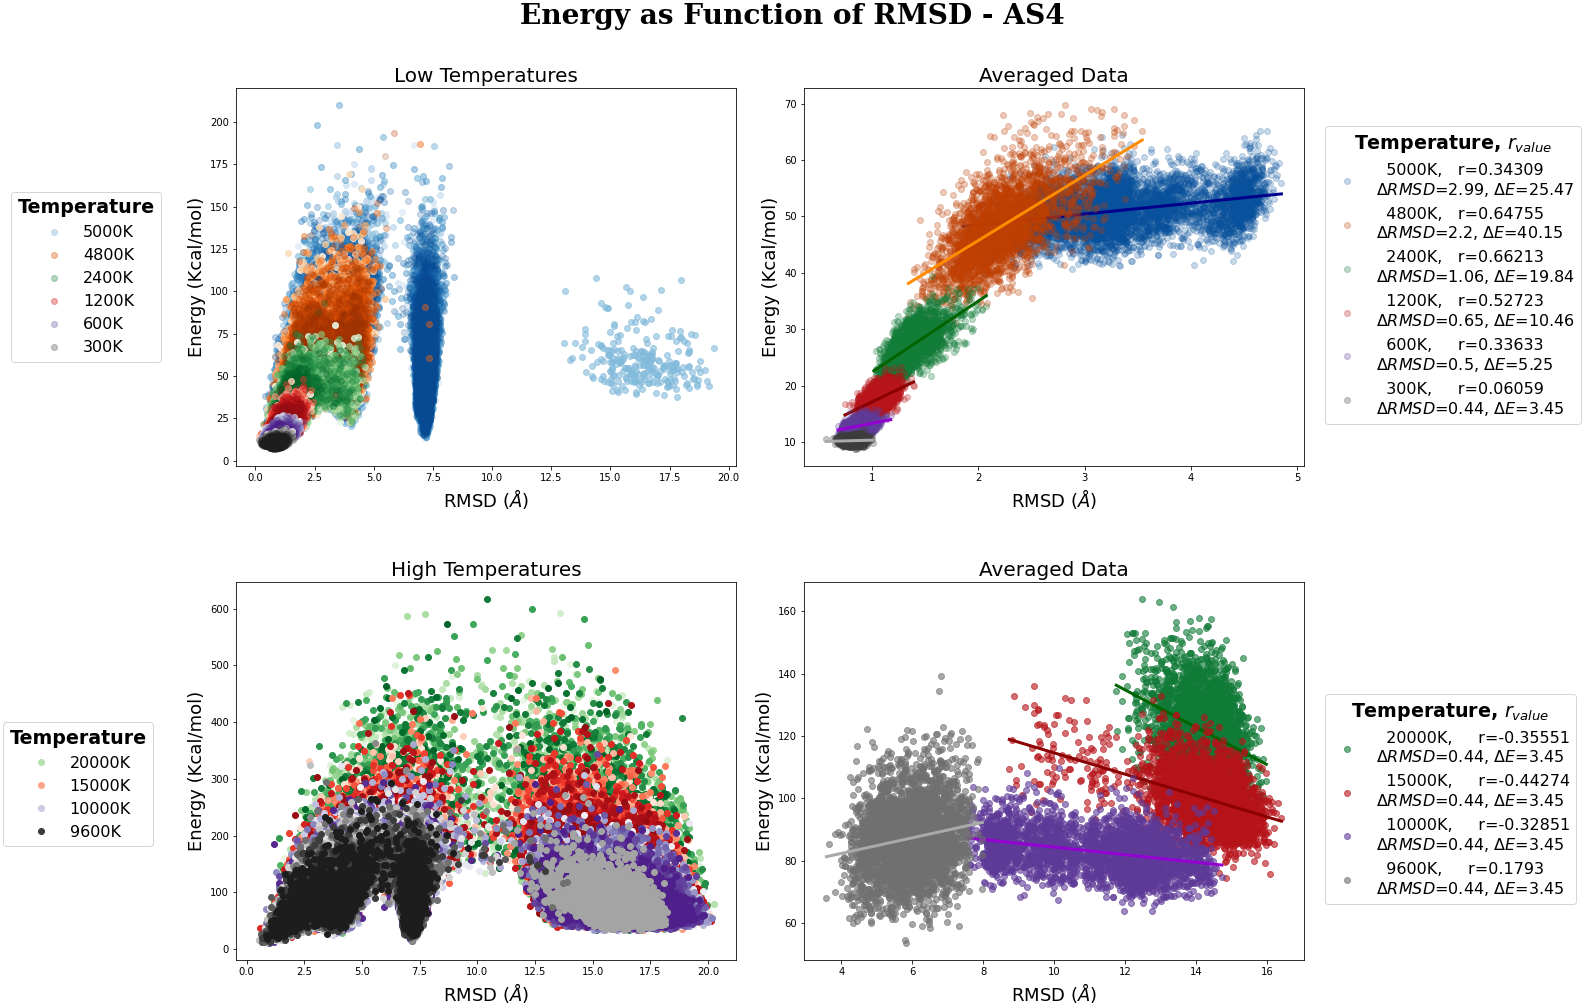

In [ ]:
def Plot_Energy(ligand, save=True):
  parameters, high_parameters = pd.DataFrame(), pd.DataFrame()
  path = root_path+'/'+ligand+'/'

  plt.close()
  #fig, axs = plt.subplots(3,2,figsize=(20,21), gridspec_kw={'hspace': 0.3})
  fig = plt.figure(layout="constrained", figsize=(22,14)) # tight_layout=True
  gs = gridspec.GridSpec(2, 2, hspace=0.1, figure=fig)

  N_plot = 5    # is used to plot, number of plots is N_samples%N_plot 
  #ax = fig.add_subplot(gs[2, :])
  axs = np.array([[fig.add_subplot(gs[0,0]),fig.add_subplot(gs[0,1])],  [fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1])]])

  c=0
  for i in range(len(temperatures)-1,-1,-1): #list(reversed((temperatures))):
    rmsd, energy = [], []
    gz_files = [f for f in listdir(path+temperatures[i]) if isfile(join(path+temperatures[i], f)) and (('mol2' not in f) and ('.gitignore' not in f))]
    
    N = len(gz_files)
    unit, unit2 = np.linspace(0.1, 0.9, N), np.linspace(0.9, 0.2, N)
    Colors = [cm.Greys(unit), cm.Purples(unit), cm.Reds(unit), cm.Greens(unit), cm.Oranges(unit), cm.Blues(unit), cm.RdPu(unit)]

    for j in range(len(temperatures)):
      for k in range(N):
        Colors[j][k][-1]=unit2[k]

    for j in range(len(gz_files)):
      data = ReadGz(path+temperatures[i]+'/'+gz_files[j])
      rmsd.append(data['RMSD']); energy.append(data['Energy'])
      if j==7:   axs[0,0].plot(data['RMSD'], data['Energy'], 'o', label=temperatures[i], color=Colors[i][j]) #colors[i], alpha=1-0.15*i)
      else:      axs[0,0].plot(data['RMSD'], data['Energy'], 'o',  color=Colors[i][j])

      rmsd_array = np.linspace(min(data['RMSD']), max(data['RMSD']), 1000)
      slope, intercept, r_value, p_value, std_err = linregress(data['RMSD'], data['Energy'])
      # axs[0].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)

      value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
                          'p_value':p_value, 'std_err':std_err, #'deltaE':float(max(energy)-min(energy)), 'deltaRMSD':float(max(rmsd)-min(rmsd)),
                          'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[c])
      parameters = pd.concat([parameters, value], ignore_index=True)
      c += 1
    
      # -------- remove repeated legend labels -------------
      # handles, labels = plt.gca().get_legend_handles_labels()
      # by_label = dict(zip(labels, handles))
      # plt.legend(by_label.values(), by_label.keys())
    
    # -------- average ------------------
    rmsd = np.average(np.array(rmsd), axis=0); energy = np.average(np.array(energy), axis=0)
    slope, intercept, r_value, p_value, std_err = linregress(rmsd, energy)
    rmsd_array = np.linspace(min(rmsd), max(rmsd), 1000)
    if len(temperatures[i]) == 4:
            label = '  '+temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
    else:    label = '  '+temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
    axs[0,1].plot(rmsd, energy, 'o', label=label, color=Colors[i][j-1])#colors[i], alpha=0.5)
    axs[0,1].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)
    
  #######################################################################################
  # --------------------------------- high temperatures --------------------------------------------
  c=0
  for i in range(len(high_temperatures)-1,-1,-1): #list(reversed((temperatures))):
    high_rmsd, high_energy = [], []
    gz_files = [f for f in listdir(path+high_temperatures[i]) if isfile(join(path+high_temperatures[i], f)) and (('mol2' not in f) and ('gitignore' not in f))]

    N_high = len(gz_files)
    unit_high, unit2_high = np.linspace(0.1, 0.9, N_high), np.linspace(0.9, 0.2, N_high)
    Colors_high = [cm.Greys(unit_high), cm.Purples(unit_high), cm.Reds(unit_high), cm.Greens(unit_high), cm.Oranges(unit_high), cm.Blues(unit_high)]

    for j in range(len(gz_files)):
      data = ReadGz(path+high_temperatures[i]+'/'+gz_files[j])
      high_rmsd.append(data['RMSD']); high_energy.append(data['Energy'])
      if j==8: axs[1,0].plot(data['RMSD'], data['Energy'], 'o', label=high_temperatures[i], color=Colors_high[i][j])
      else:     axs[1,0].plot(data['RMSD'], data['Energy'], 'o', color=Colors_high[i][j])

      rmsd_array = np.linspace(min(data['RMSD']), max(data['RMSD']), 1000)
      slope, intercept, r_value, p_value, std_err = linregress(data['RMSD'], data['Energy'])

      value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
                          'p_value':p_value, 'std_err':std_err, #'deltaE':float(max(energy)-min(energy)), 'deltaRMSD':float(max(rmsd)-min(rmsd)),
                          'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[c])
      high_parameters = pd.concat([high_parameters, value], ignore_index=True)

      c += 1
    # -------- average ------------------
    high_rmsd = np.average(np.array(high_rmsd), axis=0); high_energy = np.average(np.array(high_energy), axis=0)
    slope, intercept, r_value, p_value, std_err = linregress(high_rmsd, high_energy)
    rmsd_array = np.linspace(min(high_rmsd), max(high_rmsd), 1000)
    #if len(temperatures[i]) == 4:
    label = '  '+high_temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
    #else:    label = '  '+high_temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
    axs[1,1].plot(high_rmsd, high_energy, 'o', label=label, color=Colors_high[i][j-3], alpha=0.6)#colors[i], alpha=0.5)
    axs[1,1].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)

  # ----------- legends, labels and titles for each axis ----------------
  axs[0,0].set_ylabel('Energy (Kcal/mol)', fontsize='18'); axs[0,0].set_xlabel('RMSD ($\AA$)', fontsize='18'); 
  axs[0,0].legend(title='Temperature', bbox_to_anchor=(-.15, .725), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'}, borderaxespad=0.)
  axs[0,0].set_title('Low Temperatures', fontsize='20', fontweight='normal')
  #plt.ylim((0, 100)); plt.xlim((0, 10))

  #axs[1].sharex(axs[0,0])
  axs[0,1].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[0,1].set_ylabel('Energy (Kcal/mol)', fontsize='18')
  axs[0,1].legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, 0.92), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
  axs[0,1].set_title('Averaged Data', fontsize='20', fontweight='normal')

  axs[1,0].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[1,0].set_ylabel('Energy (Kcal/mol)', fontsize='18')
  axs[1,0].legend(title='Temperature', bbox_to_anchor=(-.15, .65), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
  axs[1,0].set_title('High Temperatures', fontsize='20', fontweight='normal')

  axs[1,1].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[1,1].set_ylabel('Energy (Kcal/mol)', fontsize='18')
  axs[1,1].legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, 0.725), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
  axs[1,1].set_title('Averaged Data', fontsize='20', fontweight='normal')

  plt.suptitle('Energy as Function of RMSD - {}\n'.format(ligand), fontsize='28', fontweight='bold', x=0.5,  fontfamily='serif') #MC Simulation with LiBELa \n
  if save is True: fig.savefig("./MC_energies.png", transparent=True)#, bbox_inches='tight')

  return fig, parameters, high_parameters

fig, parameters, high_parameters =  Plot_Energy('AS4')

In [ ]:
high_temperatures#[0]

['9600K', '10000K', '15000K', '20000K']

CPU times: user 14.7 s, sys: 474 ms, total: 15.2 s
Wall time: 15.9 s


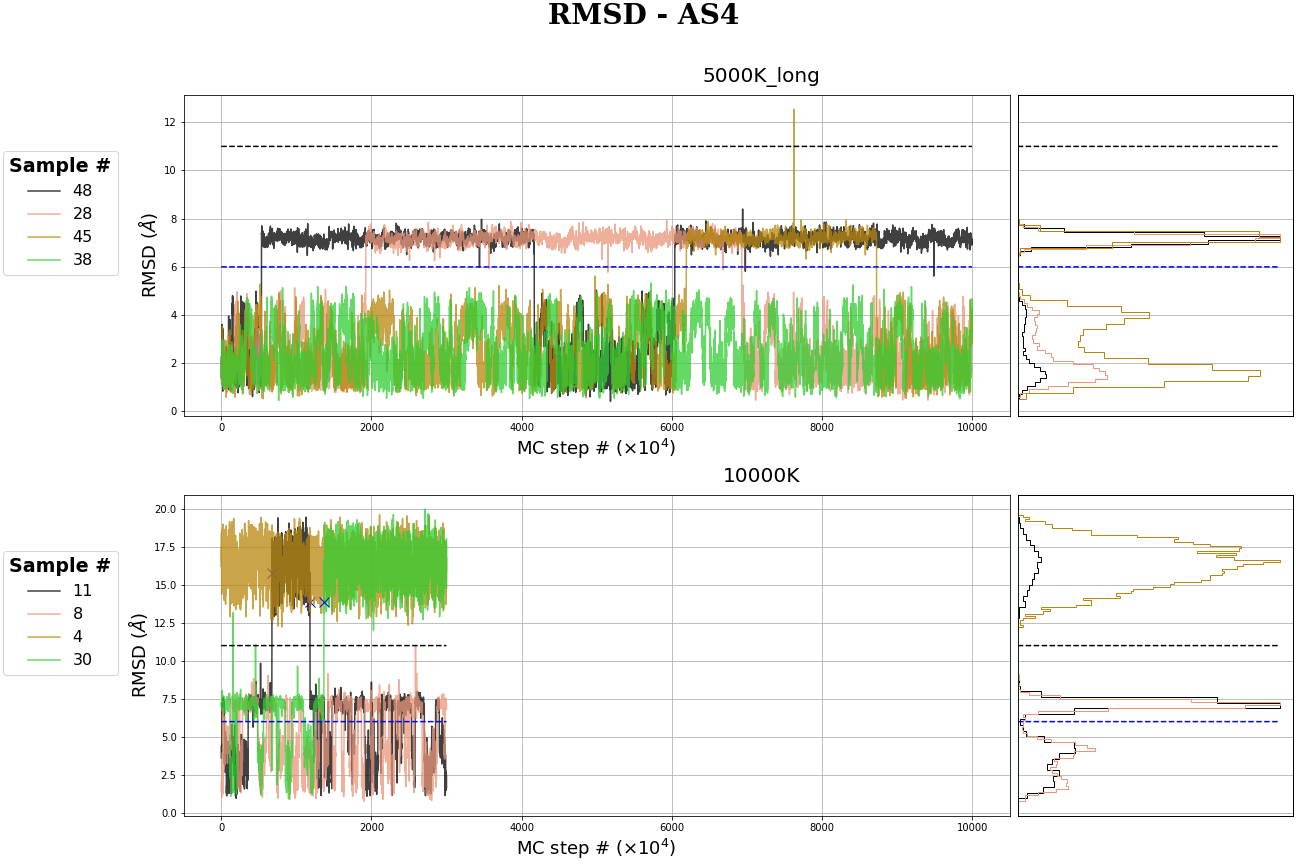

In [9]:
%%time 

def Roots(data, threshold):
  root1 = np.where(np.diff(np.sign(data['RMSD']-threshold)))[0]
  root1_selected = []
  for r in root1:
    if data.iloc[r]['RMSD'] > threshold:
      selected = r #root1_selected.append(r)
    elif data.iloc[r+1]['RMSD'] > threshold:
      selected = r+1 #root1_selected.append(r+1)
    else:
      selected = r-1 #root1_selected.append(r-1)
    
    index = np.arange(selected-10, selected+10, 1)
    over  = np.where(data.iloc[index]['RMSD'] > threshold)[0]
    lower = np.where(data.iloc[index]['RMSD'] < threshold)[0]
    if len(over)>3 and len(lower)>3:  root1_selected.append(selected)
  
  root1_selected = np.array(root1_selected)
  heights = data.iloc[root1_selected]['RMSD']
  #heights = thresholds[1]*np.ones_like(root1)
  
  return root1_selected, heights

def Roots_low(data, threshold):
  root1 = np.where(np.diff(np.sign(data['RMSD']-threshold)))[0]
  root1_selected = []
  for r in root1:
    if data.iloc[r]['RMSD'] > threshold:
      selected = r #root1_selected.append(r)
    elif data.iloc[r+1]['RMSD'] > threshold:
      selected = r+1 #root1_selected.append(r+1)
    else:
      selected = r-1 #root1_selected.append(r-1)
    
    index = np.arange(selected-10, selected+10, 1)
    over  = np.where(data.iloc[index]['RMSD'] > threshold)[0]
    lower = np.where(data.iloc[index]['RMSD'] < threshold)[0]
    if len(over)>3 and len(lower)>3:  root1_selected.append(selected)
        
  #print('selected', root1_selected)
  candidates = np.split(root1_selected, np.where(np.diff(root1_selected) > 3)[0]+1)
  selected = [int(np.mean(cand)) for cand in candidates]
  #print(candidates);    print('selected', selected)
  #selected = [x for x in candidates if len(x) > min_length]
  
  root1_selected = np.array(selected)
  heights = data.iloc[root1_selected]['RMSD']
  #heights = thresholds[1]*np.ones_like(root1)
  
  return root1_selected, heights

def Plot_RMSD(ligand, temperatures, N_plot=6, save=True, bins=100, bins_cum=50, thresholds=[6,11]):
  plt.close()
  #fig, axs = plt.subplots(len(temperatures),1, figsize=(15,6*len(temperatures)), layout="constrained", gridspec_kw={'hspace': 0.1})
  fig = plt.figure(figsize=(18,6*len(temperatures)), layout="constrained")
  gs0 = gridspec.GridSpec(len(temperatures), 1, figure=fig, hspace=0.3)

  # ----------------------------------------- cortisol -----------------------------------------
  
  path = root_path+'/'+ligand+'/'
  axs,  roots, datas = [], [], []#pd.DataFrame()
  selected = np.linspace(0,30,1)

  for i in range(len(temperatures)):
    c = 0
    gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[i,0], wspace=0.025)
    ax_main = plt.subplot(gs[0:3, :3])
    axs.append(ax_main)
    ax_yDist = plt.subplot(gs[:1, 3],sharey=ax_main)
    ax_main.grid(True); ax_yDist.grid(axis='y')

    gz_files = [f for f in listdir(path+temperatures[i]) if isfile(join(path+temperatures[i], f)) and (('mol2' not in f) and ('.gitignore' not in f))]
    for j in range(len(gz_files)):
      data = ReadGz(path+temperatures[i]+'/'+gz_files[j])
      #if j%N_plot==1: 
      if j<10 and j>5:
        ax_main.plot(1+data.index, data['RMSD'], '-', label=gz_files[j].split('_')[1], alpha=0.75, ms=3, color=several_colors[c])

        ax_yCumDist = ax_yDist.twiny()
        ax_yCumDist.hist(data['RMSD'],bins=bins_cum,cumulative=False,histtype='step',density=True,align='mid',orientation='horizontal', lw=1, color=several_colors[c])
        
        ax_yCumDist.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
        ax_yDist.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)

        # -------- looking for roots ---------        
        root1_selected, heights = Roots(data, thresholds[1])
        ax_main.plot(root1_selected+1, heights, 'x', alpha=1, ms=10, color='b')#several_colors[c]) #data.iloc[root1]['RMSD']

        roots.append(root1_selected)#_selected)
        datas.append(data)
        
        c+=25 #len(several_colors)//N_plot

    # ------ thresholds ------------
    ax_main.plot(thresholds[0]*np.ones_like(data['RMSD']), '--b');    ax_main.plot(thresholds[1]*np.ones_like(data['RMSD']), '--k')
    ax_yCumDist.plot(thresholds[0]*np.ones_like(data['RMSD']), '--b');    ax_yCumDist.plot(thresholds[1]*np.ones_like(data['RMSD']), '--k')
    
    ax_main.set_title(temperatures[i], fontsize='20', fontweight='normal', x=0.7, y=1.02)
    ax_main.set_ylabel('RMSD ($\AA$)', fontsize='18'); ax_main.set_xlabel(r'MC step # ($\times 10^4$)', fontsize='18')
    ax_main.legend(title='Sample #', bbox_to_anchor=(-0.07, 0.85), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
    #ax_main.set_xlim((0, 3000));     ax_main.set_ylim((0, 8.5))
    #if i!=0: ax_main.sharex(axs[0])

  [axs[i].sharex(axs[0]) for i in range(len(axs)) if i!=0];
  plt.suptitle('RMSD - {} \n'.format(ligand), fontsize='28', fontweight='bold', x=0.5,  fontfamily='serif')
  if save is True: fig.savefig("./MC_RMSD.png", transparent=True)#, bbox_inches='tight')

  return fig, roots, datas

fig, roots, datas = Plot_RMSD('AS4', ['5000K_long', '10000K'], N_plot=2) 

In [78]:
  #np.where(np.diff(np.sign(roots[0]-6)))#[0]
np.array(roots[0].index)[[0,1]]#iloc[[0,1]]

array([0, 1])

In [150]:
#roots = np.where(np.diff(np.sign(datas[0]['RMSD']-6)))[0]
roots[1]

array([1338])

In [151]:
#np.array(data.index)[roots[0]]
datas[1]#.iloc[roots].index

,Step,Energy,RMSD,DX,DY,DZ,ALPHA,BETA,GAMMA,NCONF,ConfEnergy,Elec,VDW,SOLV
0,10000.0,94.375,3.138,35.462700,63.881417,41.903012,272.077002,3.489696,177.240056,0.0,65.316,-1.488380,22.994486,7.553294
1,20000.0,92.093,2.338,35.692157,63.624841,40.287549,313.417442,151.655417,128.824698,0.0,58.494,-1.510075,27.851976,7.257874
2,30000.0,49.189,3.423,36.550563,63.756392,40.043927,306.796262,4.632056,168.731622,0.0,55.544,-1.722078,-11.793634,7.160890
3,40000.0,43.176,3.108,35.860696,63.517156,40.475429,40.880250,173.879453,67.495154,0.0,57.406,-2.608262,-18.984071,7.362086
4,50000.0,63.979,2.877,36.047682,64.259008,39.995418,111.256989,167.808501,344.222456,0.0,61.895,-1.823153,-2.999607,6.907186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,99960000.0,58.828,17.534,45.452512,71.102848,51.008893,290.665467,64.114637,5.199142,0.0,53.711,1.383820,-1.045611,4.778706
9996,99970000.0,55.218,16.478,43.818901,73.159678,48.884018,303.624289,29.465270,332.234880,0.0,67.746,-0.009446,-17.061683,4.543297
9997,99980000.0,118.023,18.147,46.677085,71.000163,50.787786,212.043433,65.983929,82.572925,0.0,131.416,-0.879432,-16.308655,3.795785
9998,99990000.0,46.502,15.467,43.522740,74.655242,46.395513,225.269326,167.913294,127.769105,0.0,60.607,-1.496510,-16.346218,3.737868


In [152]:
index = np.arange(roots[1][0]-10, roots[1][0]+10, 1)
over  = np.where(datas[1].iloc[index]['RMSD'] > 11)
lower = np.where(datas[1].iloc[index]['RMSD'] < 11)

In [155]:
over[0]

array([11, 12, 13, 14, 15, 16, 17, 18, 19])

In [ ]:
data.head()

,Step,Energy,RMSD,DX,DY,DZ,ALPHA,BETA,GAMMA,NCONF,ConfEnergy,Elec,VDW,SOLV
0,10000.0,55.063,13.966,42.974476,74.396607,43.621820,213.279372,60.606360,338.742595,0.0,63.238,-0.111680,-13.739133,5.675479
1,20000.0,82.900,15.199,43.214086,74.356839,47.185954,282.869746,27.469195,340.159315,0.0,57.846,-3.120422,23.165280,5.009567
2,30000.0,51.175,16.016,43.210313,74.555572,47.969140,282.872587,134.203223,150.363196,0.0,64.319,-0.251817,-16.131477,3.239479
3,40000.0,77.107,16.477,44.381310,74.776208,46.744782,242.798193,1.225647,146.742266,0.0,74.033,-3.057820,3.115036,3.016576
4,50000.0,83.990,14.261,47.225283,70.854486,37.260106,262.764370,89.052510,130.347409,0.0,72.378,0.236631,5.346602,6.028273


In [ ]:
parameters.head()

,temperature,slope,intercept,r_value,p_value,std_err,E_mean,RMSD_mean
0,9600K,3.799543,68.758328,0.227778,1.316782e-36,0.296643,87.210101,4.856314
1,9600K,2.770714,74.310722,0.154264,1.949528e-17,0.324102,88.023703,5.049608
2,9600K,3.483445,69.269940,0.209201,5.084069e-31,0.297380,87.904365,5.126708
3,9600K,-0.594173,92.285054,-0.091236,5.570526e-07,0.118445,87.069781,7.092834
4,9600K,3.584968,71.198456,0.202779,3.298446e-29,0.316176,87.504540,6.680978


In [ ]:
high_parameters.head()

,temperature,slope,intercept,r_value,p_value,std_err,E_mean,RMSD_mean
0,1200K,-8.094530,238.962705,-0.334135,3.703433e-79,0.417010,10.240653,0.818284
1,1200K,-6.634840,216.806037,-0.360067,1.616823e-92,0.313963,10.240653,0.818284
2,1200K,-5.209953,196.663515,-0.352731,1.309437e-88,0.252419,10.240653,0.818284
3,1200K,-6.401936,215.849036,-0.351914,3.515288e-88,0.310992,10.240653,0.818284
4,1200K,-5.605740,201.984871,-0.359816,2.208350e-92,0.265478,10.240653,0.818284


In [ ]:
# plt.close()
# fig = plt.figure(figsize=(12,7))

# parameters = pd.DataFrame()

# for i in range(len(temperatures)-1,-1,-1):#list(reversed((temperatures))):
#   rmsd, energy = [], []
#   for file in gz_files:
#     data = ReadGz(path+temperatures[i]+'/'+file)
#     rmsd.append(data['RMSD']); energy.append(data['Energy'])
#     #plt.plot(data['RMSD'], data['Energy'], 'o', label=temp)
  
#   rmsd = np.average(np.array(rmsd), axis=0); energy = np.average(np.array(energy), axis=0)
#   slope, intercept, r_value, p_value, std_err = linregress(rmsd, energy)

#   value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
#                         'p_value':p_value, 'std_err':std_err, 'deltaE':max(energy)-min(energy), 'deltaRMSD':max(rmsd)-min(rmsd),
#                         'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[i])
#   parameters = pd.concat([parameters, value], ignore_index=True)

#   rmsd_array = np.linspace(min(rmsd), max(rmsd), 1000)
#   if len(temperatures[i]) == 4:
#            label = '  '+temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
#   else:    label = '  '+temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  
#   plt.plot(rmsd, energy, 'o', label=label, color=colors[i], alpha=0.5)
#   plt.plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)
  
# plt.xlabel('RMSD ($\AA$)', fontsize='18'); plt.ylabel('Energy (Kcal/mol)', fontsize='18')
# plt.legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, .85), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
# plt.title('Average MC Data', fontsize='20', fontweight='bold')
# #plt.ylim((0, 100)); plt.xlim((0, 10))


# fig.tight_layout()

In [ ]:
parameters

,temperature,slope,intercept,r_value,p_value,std_err,deltaE,deltaRMSD,E_mean,RMSD_mean
0,9600K,3.618476,68.128719,0.189429,1.237636e-25,0.342554,88.1144,4.0729,86.377283,5.043162
1,4800K,7.686823,25.420495,0.489727,9.033058e-181,0.249937,39.4214,2.3833,48.524411,3.005652
2,2400K,11.422871,11.276015,0.616388,1.728381e-313,0.266517,21.2101,1.2229,27.205981,1.394568
3,1200K,10.020911,7.149810,0.572122,1.938263e-260,0.262365,10.4608,0.6064,17.830673,1.065857
4,600K,3.986522,9.410569,0.359297,4.207386e-92,0.189108,5.8456,0.5102,12.935471,0.884205
5,300K,0.883189,9.500466,0.105896,6.096991e-09,0.151465,3.0744,0.4169,10.224093,0.819335
